## Clean version of post_pro_landau_rel for D=2

We use it and then move the results to Notes_log.

In [1]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
import Pkg; Pkg.add("LaTeXStrings")
using LaTeXStrings
using Printf
using LsqFit
using LinearAlgebra

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [2]:
const D = 2

2

In [3]:
include("aux_functions/aux_functions.jl")

plot_matrix

In [4]:
outputs = false # detailed output (no longer used)
average_outputs =false
full_outputs = true
animation = false # to run animations
phase_space_show = false #show phase space diagrams
phase_space_show = true
remote_server = false # if run in remote as a script avoid all plots 
save_plots = true # put true is you want so save your plots.
plots = true

true

We first introduce the name of the file with the data and retrieve the metadata.

In [5]:
#file_name = "Results/norel_norm_undamped_rel_t400_L4_N85_n2_J80_M16001_o5_Th3_alp2_ave.jld2"
#file_name = "Results/norel_norm_undamped_rel_t400_L4_N86_n2_J80_M16001_o5_Th3_alp2_ave.jld2"
#file_name = "Results/norel_norm_undamped_rel_t400_L39.738_N86_n2_J3522_M16001_o5_Th3_alp2_ave.jld2"
#file_name = "Results/norel_norm_damped_rel_t40_L7.455_N85_n15_J930_M16001_o4_Th3_alp2_ave.jld2"
#file_name = "Results/weibel_Box_1.0x1.0_J_50x100_Ax_25_Th3_alp8tf_1_N7_M11_o5_B0_0_full.jld2"
#file_name = "Results/thermal_rel_Box_1.0x1.0_J_100x100_nm_[1,1]__Th3_alp1tf_100_N5_M1001_o5_B0_0_full.jld2"
#file_name = "Results/thermal_rel_Box_1.0x1.0_J_50x50_nm_[1,1]__Th3_alp1tf_100_N6_M5001_o5_B0_0_full.jld2"
#file_name = "Results/weibel_Box_1.0x1.0_J_50x50_Ax_25_Th3_alp8tf_100_N6_M5001_o5_B0_1_full.jld2"
#file_name = "Results/weibel_Box_1.0x1.0_J_50x50_Ax_25_Th3_alp8tf_100_N7_M5001_o5_B0_1_full.jld2"
#file_name = "Results/weibel_Box_1.0x1.0_J_50x50_Ax_25_Th3_alp8tf_1000_N6_M50001_o5_B0_1_full.jld2"
file_name = "Results/weibel_Box_1.0x1.0_J_50x50_Ax_25_Th3_alp8tf_4000_N6_M50001_o5_B0_1_full.jld2"

"Results/weibel_Box_1.0x1.0_J_50x50_Ax_25_Th3_alp8tf_4000_N6_M50001_o5_B0_1_full.jld2"

In [6]:

data, run_name, par_grid, par_evolv, par_f, n0, xs, t_series = retrieve_meta_data_D(file_name)
@show run_name
@show par_grid
@show par_evolv
@show par_f
@show (N, J, Box_x, order) = par_grid
@show (t_i, t_f, M, M_g, dt) = par_evolv
#@show (θ, nm, k) = par_f

dT = dt*(M-1)/(M_g-1)


#freqs_space = L*rfftfreq(J, 1/dx)

M_last = M_g  # number of last data point saved. Otherwise use M_g
#freqs_time = fftshift(rfftfreq(M_last, 1/dT))
#freqs_time = rfftfreq(M_last, 1/dT)*2*π;

dx = differentials(Box_x,J)
x_p = [dx[1]*(i-1) for i in 1:J[1]] ;
y_p = [dx[2]*(i-1) for i in 1:J[2]] ;

run_name = "weibel_Box_1.0x1.0_J_50x50_Ax_25_Th3_alp8tf_4000_N6_M50001_o5_B0_1"
par_grid = (1000000, (50, 50), (0.0, 1.0, 0.0, 1.0), 5)


par_evolv = (0.0, 400.0, 50001, 401, 0.008)
par_f = 

((1.0e-8, [0.0, 0.0], (0.0, 1.0, 0.0, 1.0)), (0.001, 0.025, [0.5, 0.0], 0.007760848597927437, 2))
(N, J, Box_x, order) = par_grid = (1000000, (50, 50), (0.0, 1.0, 0.0, 1.0), 5)
(t_i, t_f, M, M_g, dt) = par_evolv = (0.0, 400.0, 50001, 401, 0.008)


In [7]:
if false
f_test(t) = sin(2*π*5*t)
F_test = rfft(f_test.(t_series))
freqs_time_test = (rfftfreq(M_g, 1/dT));
Plots.scatter(freqs_time_test, (abs.(F_test)))
end

We can have data written out in full o in averaged format: In each case we use different functions. Data written in full has a `"full.jld2"` at the end, otherwise a `"ave.jld2"` is used.

For the full case we use:

```
v = retrieve_data_D(data, par_grid, par_evolv);
```
```
Energy_K, Energy_E, EField_T, p_T, Q_T, S_T, T = get_averages_threads_D(v,par_grid,par_evolv, par_f);
```

For the averaged case we use:

```
M_last = 1601 # number of iterations already completed. 

n_t, S_t, Efield_t, averages = retrieve_average_data_D(data, par_grid, par_evolv;M_last=M_last);

Energy_E,  Energy_K, EField_T, p_T, Q_T, S_T, T = averages;
```



In [8]:
M_last = M_g
if average_outputs
n_t, S_t, Efield_t, averages = retrieve_average_data_D(data, par_grid, par_evolv;M_last=M_last);

Energy_E,  Energy_K, EField_T, p_T, Q_T, S_T, T = averages;

elseif full_outputs
    v = retrieve_data_D(data, par_grid, par_evolv; M_last=M_last);
end

v = zeros((2D) * N + 3 * prod(J), M_g) = [0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.

 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.

.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

Excessive output truncated after 590585 bytes.

4007500×401 Matrix{Float64}:
  0.666426      0.567539      0.537424     …   0.653872     0.57648
  0.609321      0.637709      0.735962         0.599512     0.680966
 -0.105355     -0.0767939     0.0212186       -0.112406    -0.0303058
 -0.0231284     0.0754941     0.105673         0.0361465    0.11397
  0.942307      0.987156      0.0774836        0.891643     0.980402
  0.203576      0.282196      0.287296     …   0.287237     0.257893
  0.00211016    0.0804964     0.0856024        0.0963312    0.0671038
  0.0947416     0.0499514    -0.0406257        0.0171452   -0.071394
  0.115181      0.154107      0.182694         0.265419     0.228377
  0.656823      0.665533      0.637496         0.54177      0.499083
  ⋮                                        ⋱                ⋮
  6.04753e-5    0.000409143  -0.000700447     -0.00201232  -0.00270681
  0.000745509   0.000281309  -0.000517224      0.00234502   0.00260931
  1.0           1.00005       1.00001          0.99988      0.999984
  0.0001

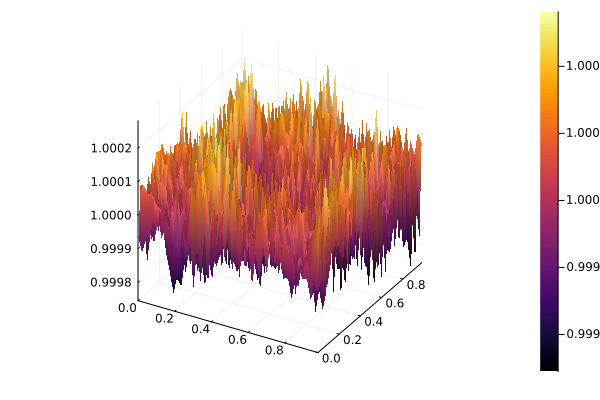

In [9]:
j = M_last
Fuj = view(v[:,j],4N+1:4N+3*prod(J))

Fj = reshape(Fuj,3,J...)

#F = view(u[4N+1:end],3,J...)
Ej = Fj[1:2,:,:]
Bj = Fj[3,:,:];

#surface(y_p,x_p,Ej[2,:,:])
surface(y_p,x_p,Bj[:,:])

#norm(Bj)

In [10]:
E_E = zeros(M_last)
E_K = zeros(M_last)
for j in 1:M_last
E_K[j], E_E[j]  = get_energy_rel(v[:,j],(Box_x, N, J))
end

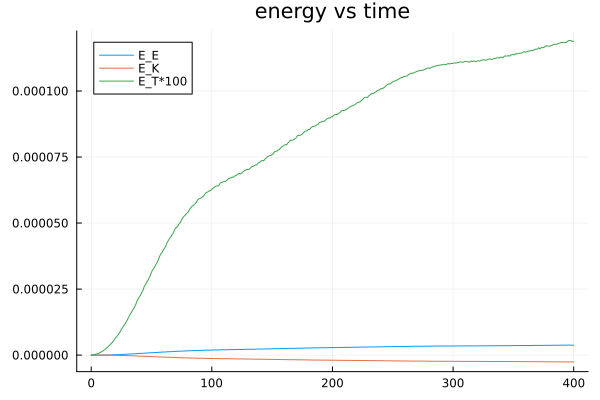

In [11]:
factor = 100
plot(title="energy vs time")
plot!(t_series[1:M_last],E_E .-E_E[1],label="E_E")
plot!(t_series[1:M_last],E_K .-E_K[1],label="E_K")
plot!(t_series[1:M_last],factor*(E_E + E_K .- (E_E[1]+E_K[1])), label="E_T*$(factor)")
#png("Notes/Weibel/energy_vs_time_N6_longlong")

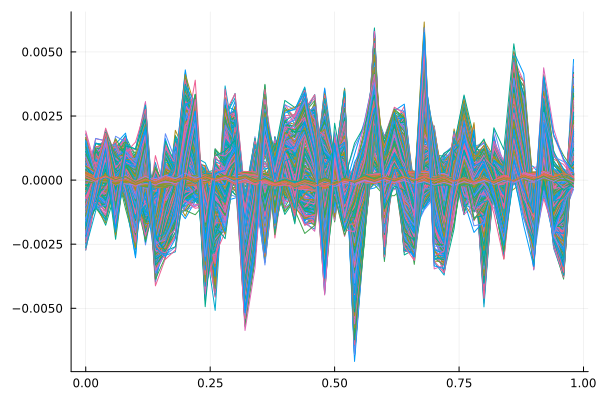

In [12]:
l = 1
P = 25
plot(legend=false)
#plot()
for j in 1:M_last
    Fuj = view(v[:,j],4N+1:4N+3*prod(J))
    Fj = reshape(Fuj,3,J...)
    Ej = Fj[1:2,:,:]
    Bj = Fj[3,:,:];
    plot!(y_p,Ej[l,:,P], label="E($l)")
    plot!(y_p,Bj[:,P].-1.0, label="B-1")
    
end
plot!()

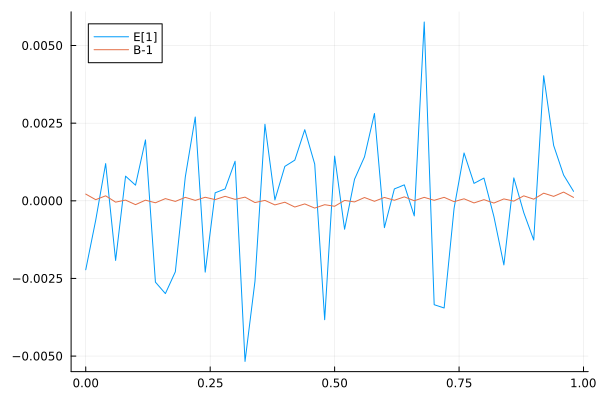

In [13]:
l = 1
P = 25
#plot(legend=false)
plot()
j = M_last
    Fuj = view(v[:,j],4N+1:4N+3*prod(J))
    Fj = reshape(Fuj,3,J...)
    Ej = Fj[1:2,:,:]
    Bj = Fj[3,:,:];
    plot!(y_p,Ej[l,:,P], label="E[$l]")
    #png("E_field_M_g")
    plot!(y_p,Bj[:,P].-1.0, label="B-1")
    #png("Notes/Weibel/E_B_field_M_g_N6_long")
    

In [14]:
get_density_2D_trans = Density2DTrans(N, J)
get_current_2D_trans = Current2DTrans(N, J)


Current2DTrans(1000000, (50, 50), [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.

In [15]:
nf = get_density_2D_trans(Val(order), Box_x, v[1:2D*N,M_last])
ρf = nf .-1.0;
@show sum(nf)/prod(J)
S = get_current_2D_trans(Val(order), Box_x, v[1:2D*N,M_last] )
@show sum(S[:,:,1]/prod(J))

-1.5397980290508681e-7

### Constraint check

In [16]:
Fuj = view(v[:,M_last],4N+1:4N+3*prod(J))
Fj = reshape(Fuj,3,J...)
Ej = Fj[1:2,:,:]
Err = 0.0
Max = 0.0
r0 = 0.2
M_test = 4000
x0=zeros(M_test,D)
err = zeros(M_test)
rho = zeros(M_test)
for i in 1:M_test
    x0[i,:]=[Box_x[1] + (Box_x[2]-Box_x[1])*rand(), Box_x[3] + (Box_x[4]-Box_x[3])*rand()]
    pars = (x0[i,:], r0, 6)
    div, rho[i], err[i] = constraint_test(Ej, ρf, J, Box_x, ϕ_test, ∇ϕ_test, pars)
    global Err = Err + abs(err[i])
    if err[i] > Max
        @show Max = err[i]
        @show x0[i]
    end
end
println("error = $(Err/M_test)")
println("Max = $(Max)")

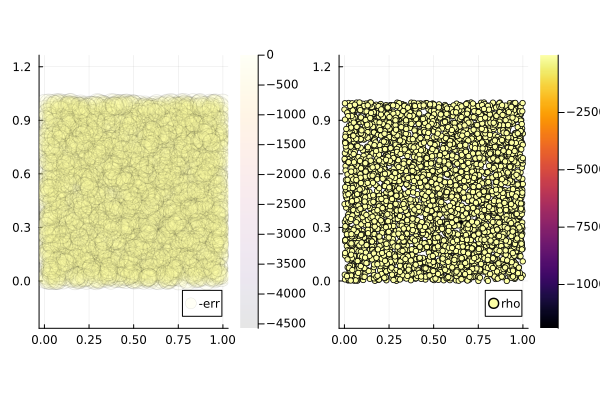

In [47]:

p1 = Plots.scatter(x0[:,1],x0[:,2],marker_z=-err[:], markersize=10, alpha=0.1, label="-err", aspectratio=1)
p2 = Plots.scatter(x0[:,1],x0[:,2],marker_z=-1.0./abs.(rho[:])./100, markersize=3, alpha=1, label="rho", aspectratio=1)
plot(p1,p2,layout = (1, 2))

#png("Notes/Weibel/div_error_test_long-longN7")

In [18]:
println("error = $(Err/M_test)")
println("Max = $(Max)")

In [19]:
Err/M_test

1.2447961412074124

In [20]:
Max

4573.632149712484

In [48]:
histogram(err)
#png("Notes/Weibel/error-histogram_N6_long-long")

"Notes/Weibel/error-histogram_N6_long-long.png"

## Temperature

In [49]:
T = [get_temperature_rel_D(v[1:2D*N,j],N,D) for j in 1:M_last]
plot(t_series[1:M_last],T, label="T")
#png("Notes/Weibel/Temperature_N6_long-long")

"Notes/Weibel/Temperature_N6_long-long.png"

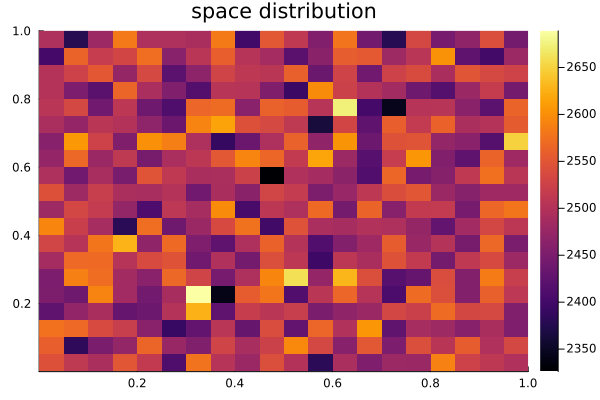

In [23]:
plot(histogram2d(v[1:2D:2D*N-3,j],v[2:2D:2D*N-2,j], title="space distribution" ))
#png("Notes/Weibel/final_space_distribution_N7")

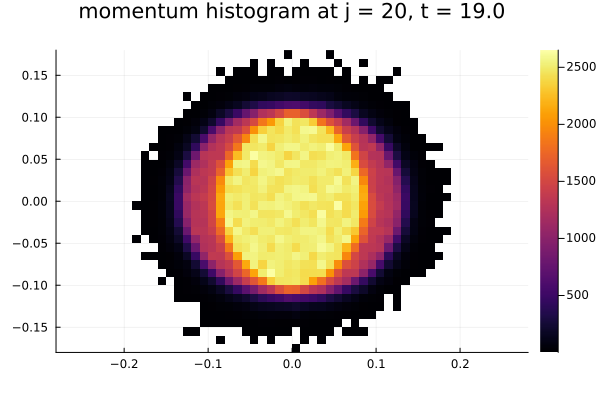

In [24]:
j = 20 #4# 16 #M_last
plot(histogram2d(v[3:4:2D*N-1,j],v[4:4:2D*N,j] )
,aspectratio=1
,title = "momentum histogram at j = $j, t = $(t_series[j])"
)
#png("Notes/Weibel/initial_momentum_histogram_N6")
#png("Notes/Weibel/final_momentum_histogram_N6")
#png("Notes/Weibel/momentum_histogram-j-$(j)_N7")

### Momentum Rotation

To meassure the momentum rotation we look at 

$$
\theta_m = \frac{<|p_x|>}{\sqrt{<|p_x|>^2+<|p_y|>^2}}
$$

In [84]:
θ_m = zeros(M_last)
B0=1



for j in 1:M_last
    θ_m[j] = get_theta_x(N, v[1:4N,j], Val(2))
end


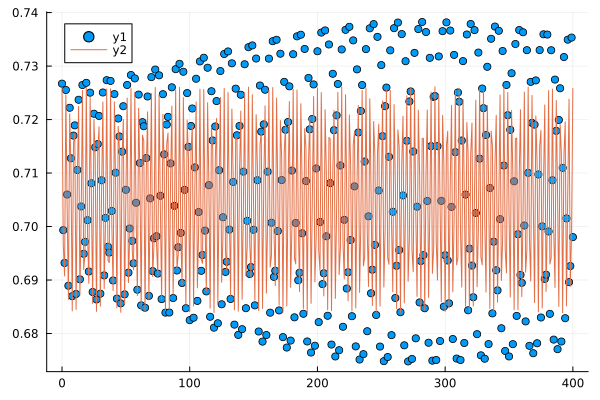

In [86]:

#@. θ_mod(t,p) = p[1] + (p[2] + p[4]*t)*cos(p[3]*t)^2
@. θ_mod(t,p) = 0.705 + 0.021*cos(1.9795*t) + p[4]*cos(p[5]*t+p[6])

Nmax = 100 #M_last
θ_fit = curve_fit(θ_mod, t_series[1:Nmax], θ_m[1:Nmax], [0.68, 0.03, 2.0, 0.01,2.30,0.0]) 
Plots.scatter(t_series[1:M_last],θ_m)
plot!(t_series[1:M_last],θ_mod(t_series[1:M_last],θ_fit.param))
#png("Notes/Weibel/theta_fit_N7.png",)


In [87]:
θ_fit.param

6-element Vector{Float64}:
 0.68
 0.03
 2.0
 0.00013409527025777008
 2.2299489482062
 8.42313473710076

## Averaged section

In [27]:

plot_averages(averages, t_series[1:M_last], N, run_name, save_plots)

UndefVarError: UndefVarError: `averages` not defined

In [28]:
C_i = 0.060145630933730654 + 0.31190415932386045im

Plots.scatter(t_series[1:M_last],E_mode[1:M_last], markersize=1)
@. model_mode(x,p) = abs(real((p[1]+im*p[2])*exp(im*(p[3]+im*p[4])*x)))
N_i = 10
N_f = M_last
pm = [real.(C_i); imag.(C_i);1.1; 0.10]
#model_mode(2,pm)
fit_E_mode = curve_fit(model_mode, t_series[N_i:N_f], E_mode[N_i:N_f], pm);
plot!(t_series[N_i:N_f], model_mode(t_series[N_i:N_f],fit_E_mode.param))
#fit_E_mode.param
if save_plots
    png("Images/" * run_name * "_single_mode_fit.png")
end

UndefVarError: UndefVarError: `E_mode` not defined

In [29]:
fit_E_mode.param

UndefVarError: UndefVarError: `fit_E_mode` not defined

#### Energy fit 

In [30]:
plot_energies(Energy_K, Energy_E, t_series[1:M_last], run_name, save_plots)

UndefVarError: UndefVarError: `Energy_K` not defined

In [31]:
@. model_e1(x,p) =  p[1] + p[2]*cos(p[3]*x + p[4])*exp(-p[5]*x) + p[6]*cos(p[7]*x + p[8])*exp(-p[9]*x)
@. model_e2(x,p) = p[1] + p[2]*(cos(p[3]*x + p[4])^2 - p[6])*exp(-p[5]*x)
@. model_e3(x,p) = p[1] + (p[2]*cos(p[3]*x + p[4])*exp(-p[5]*x) + p[6]*cos(p[7]*x + p[8])*exp(-p[9]*x))^2

pe_1 = [0.00001; 0.0001; 2; 0; 0.002; 0.00001; 2; 0; 0.0]
pe_2 = [0.0001; -0.0001; 1; 0; 0.000; 0.5]

#pe = [0.001; 0.001; 2.03; 2; 0.002; 0.001; 3.0; 0.0; 0.0]
#pe = [0.01; -0.01; 1; 0; 0.002; 0.0]
pe_3 = [0.00001; 0.001; 1.0; 2; 0.000; 0.001; 1.002; 0.0; 0.000]
#pe_3 = fit_e.param
fit_e, plt = energy_fit(t_series, Energy_E, model_e2, pe_2, 10, M_last, run_name, save_plots, yscale=:identity)
plt 

UndefVarError: UndefVarError: `Energy_E` not defined

In [32]:
fit_e.param

UndefVarError: UndefVarError: `fit_e` not defined

#### Temperature Fit

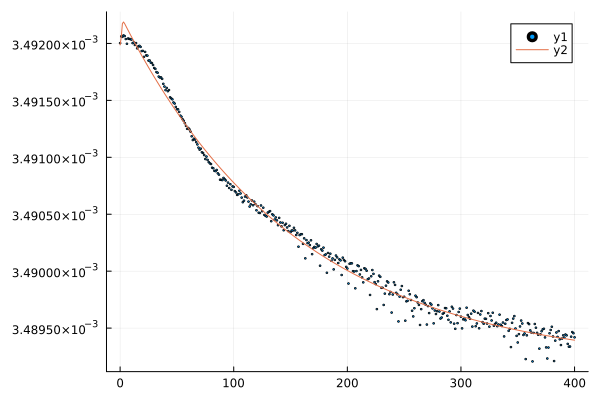

In [33]:
N_i = 1
N_f = M_last
p_tl001 = [0.001; 0.001; 2.02; 0; 0.0; 0.; 2.0; 0; 0]
fit_T_1, plt = temperature_fit(t_series, T, p_tl001, N_i, N_f, run_name, save_plots)
plt

In [34]:
#model_tl001(x,p) = p[1] + p[2]*cos(p[3]*x + p[4])*exp(-p[5]*x) + p[6]*cos(p[7]*x + p[8])*exp(-p[9]*x)
fit_T_1.param

9-element Vector{Float64}:
  0.0034891645647972835
 -1.3900144428215052e-6
  0.673782993755025
 -1.3782847578289055
  1.7871877236559899
 -7.626655426942602e-5
  1.4518704708647561e-6
  1.6113053004816182
  0.006535973380356898

In [35]:
ΔT = T .- sum(T)/length(T)
T_F = rfft(ΔT)
Plots.scatter(freqs_time,abs.((T_F)), title = " Temperature Spectrum", label="abs.(T_F)",legend=:topleft
, xticks=1.9:0.05:2.3, xlim=(1.9,2.3)
)
#=
Plots.scatter(abs.((T_F)), title = "Spectrum", label="abs.(T_F)",legend=:topleft
    , xticks=100:1:200, xlim=(120,140)
    )
    =#

    if save_plots
        png("Images/" * run_name * "_temperature_spectrum.png")
    end

UndefVarError: UndefVarError: `freqs_time` not defined

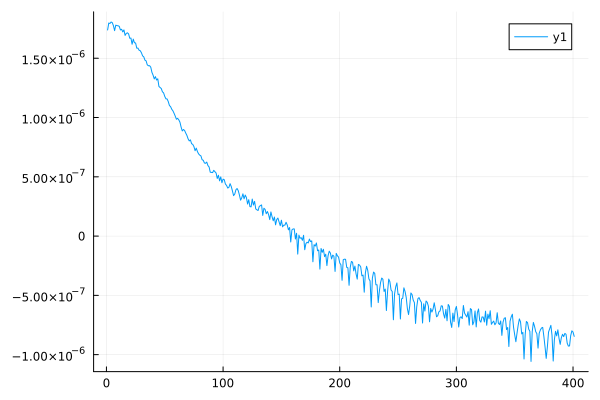

In [36]:
plot(ΔT)

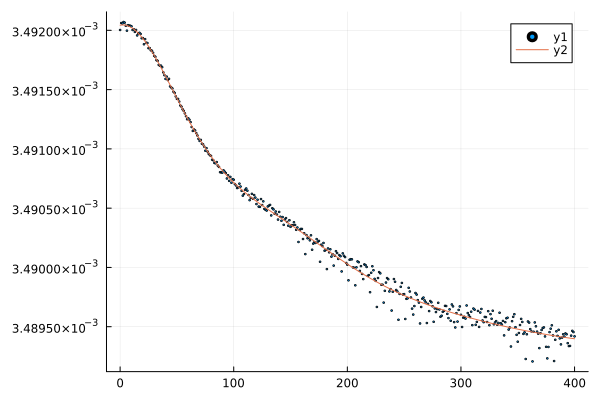

In [37]:
N_i = 1
N_f = M_last
p_tl001 = [0.00; 0.001; 2.02; 0; 0.0; 0.; 2.0; 0; 0]
fit_ΔT_1, plt = temperature_fit(t_series, T, p_tl001, N_i, N_f, run_name, save_plots)
plt

In [38]:
fit_ΔT_1.param

9-element Vector{Float64}:
  0.0034892491804519926
  4.1994314972816037e-7
  0.0396332721060143
 -1.039497889807978
  0.01648014422734079
 -0.00012369989711268696
  0.00014764872808750005
  1.5916633987654054
  0.010475305023157645

#### Density study

In [39]:
plot(n_t[:,M_last])

UndefVarError: UndefVarError: `n_t` not defined

In [40]:
n_F = rfft(n_t[:,M_last].-1); # we take out the background
#n_F = rfft(n_t[:,1].-1); # we take out the background

UndefVarError: UndefVarError: `n_t` not defined

In [41]:
Plots.scatter(freqs_space,abs.((n_F)), title = "Density Spectrum", label="abs.(n_F)",legend=:topleft
    , xticks=0:0.2:6
    , xlim=(0,6)
    )
    #recall that it is shifted one position to the right, so the frequency is 20.

UndefVarError: UndefVarError: `freqs_space` not defined

In [42]:
3/2*0.1^2

0.015000000000000003

In [43]:
2.012904971545909/2

1.0064524857729544

In [44]:
2.0033087748744984/2



1.0016543874372492